In [1]:
# import modules
%run -i '/nfs/see-fs-02_users/earlacoa/wrf-analysis/misc/modules_python3.py'
%matplotlib inline

### GBD2019

In [2]:
# risk based on five cohorts from Canada, the UK, and the US
# COPD mortality only
# maximum 6month mean, dailymaximum, 8hour, O3 concentrations (6mDM8h)
# beta is from the hazard ratios (HR)
# COPD: [1.063 (95% CI 1.029, 1.098)]
hr_copd_mean  = 1.063
hr_copd_sd    = (1.063 - 1.029) / 2
hr_copd_upper = 1.098
hr_copd_lower = 1.029

# HR = exp(beta * delta(Y))
# where delta(Y) is the increase per 10ppb, therefore:
# beta = ln(HR)/10
beta_copd_mean  = np.log(hr_copd_mean)/10
beta_copd_lower = np.log(hr_copd_lower)/10
beta_copd_upper = np.log(hr_copd_upper)/10
beta_copd_sd    = (beta_copd_mean - beta_copd_lower) / 2

# using larger LCC
lccmin = 29.1
lccfifth = 35.7

In [3]:
# function to determine mean and upper and lower confidence intervals at 95%
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * sp.stats.t._ppf((1+confidence)/2., n-1)
    return m, m-h, m+h

True
True


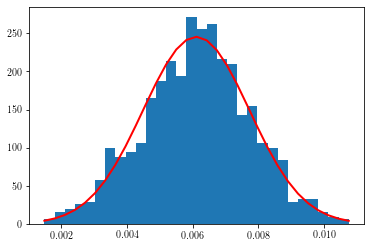

Beta GBD sampled copd, mean:  0.006117799081885897
Beta GBD sampled copd, upper: 0.005086193232253056
Beta GBD sampled copd, lower: 0.007149404931518737


In [7]:
# sample 1000 estimates of beta from normal distributions using 95% uncertainties
# apply each result to the attributable fraction, AF = (1 \u2212 exp(-beta * delta(X)))
# use the resulting distribution of AF to determine mean AF, upper AF and lower AF (95% uncertainties)

# copd
mu, sigma = beta_copd_mean, beta_copd_sd # mean and standard deviation
s = np.random.normal(mu, sigma, 1000) # 1000 samples within the normal distribution
# verify the distribution
print(abs(mu - np.mean(s)) < 0.01)
print(abs(sigma - np.std(s, ddof=1)) < 0.01)
# Display the histogram of the samples, along with the probability density function:
count, bins, ignored = plt.hist(s, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=2, color='r')
plt.show()
beta_sampled_copd_mean, beta_sampled_copd_upper, beta_sampled_copd_lower = mean_confidence_interval(bins, confidence=0.95)
print('Beta GBD sampled copd, mean:  ' + str(beta_sampled_copd_mean))
print('Beta GBD sampled copd, upper: ' + str(beta_sampled_copd_upper))
print('Beta GBD sampled copd, lower: ' + str(beta_sampled_copd_lower))

In [8]:
# create lookup table for attributable risk using the beta sampled with 1000 random samples: (1 \u2212 exp(-beta * delta(X)))
# for a given concentration of O3 between 0 and 200ppb
rr_copd_mean_lccmin  = np.empty([0])
rr_copd_lower_lccmin = np.empty([0])
rr_copd_upper_lccmin = np.empty([0])
rr_copd_mean_lccfifth  = np.empty([0])
rr_copd_lower_lccfifth = np.empty([0])
rr_copd_upper_lccfifth = np.empty([0])
for o3 in np.arange(0.0,200.0,0.1):
    if o3 < lccmin:
        rr_copd_mean_lccmin  = np.append(rr_copd_mean_lccmin, 1 - np.exp(-beta_sampled_copd_mean * (0)))
        rr_copd_lower_lccmin = np.append(rr_copd_lower_lccmin, 1 - np.exp(-beta_sampled_copd_lower * (0)))
        rr_copd_upper_lccmin = np.append(rr_copd_upper_lccmin, 1 - np.exp(-beta_sampled_copd_upper * (0)))
    if o3 >= lccmin:
        rr_copd_mean_lccmin  = np.append(rr_copd_mean_lccmin, 1 - np.exp(-beta_sampled_copd_mean * (o3 - lccmin)))
        rr_copd_lower_lccmin = np.append(rr_copd_lower_lccmin, 1 - np.exp(-beta_sampled_copd_lower * (o3 - lccmin)))
        rr_copd_upper_lccmin = np.append(rr_copd_upper_lccmin, 1 - np.exp(-beta_sampled_copd_upper * (o3 - lccmin)))
    if o3 < lccfifth:
        rr_copd_mean_lccfifth  = np.append(rr_copd_mean_lccfifth, 1 - np.exp(-beta_sampled_copd_mean * (0)))
        rr_copd_lower_lccfifth = np.append(rr_copd_lower_lccfifth, 1 - np.exp(-beta_sampled_copd_lower * (0)))
        rr_copd_upper_lccfifth = np.append(rr_copd_upper_lccfifth, 1 - np.exp(-beta_sampled_copd_upper * (0)))
    if o3 >= lccfifth:
        rr_copd_mean_lccfifth  = np.append(rr_copd_mean_lccfifth, 1 - np.exp(-beta_sampled_copd_mean * (o3 - lccfifth)))
        rr_copd_lower_lccfifth = np.append(rr_copd_lower_lccfifth, 1 - np.exp(-beta_sampled_copd_lower * (o3 - lccfifth)))
        rr_copd_upper_lccfifth = np.append(rr_copd_upper_lccfifth, 1 - np.exp(-beta_sampled_copd_upper * (o3 - lccfifth)))

In [9]:
o3_array = np.asarray(np.arange(0.0,200.0,0.1))
df_o3 = pd.DataFrame(o3_array)
df_o3['AF COPD mean with LCCmin'] = pd.Series(rr_copd_mean_lccmin)
df_o3['AF COPD lower with LCCmin'] = pd.Series(rr_copd_lower_lccmin)
df_o3['AF COPD upper with LCCmin'] = pd.Series(rr_copd_upper_lccmin)
df_o3['AF COPD mean with LCCfifth'] = pd.Series(rr_copd_mean_lccfifth)
df_o3['AF COPD lower with LCCfifth'] = pd.Series(rr_copd_lower_lccfifth)
df_o3['AF COPD upper with LCCfifth'] = pd.Series(rr_copd_upper_lccfifth)
df_o3.columns = ['O3 (ppb)', 'AF COPD mean with LCCmin', 'AF COPD upper with LCCmin', 'AF COPD lower with LCCmin', 'AF COPD mean with LCCfifth', 'AF COPD upper with LCCfifth', 'AF COPD lower with LCCfifth']
df_o3.tail()

,O3 (ppb),AF COPD mean with LCCmin,AF COPD upper with LCCmin,AF COPD lower with LCCmin,AF COPD mean with LCCfifth,AF COPD upper with LCCfifth,AF COPD lower with LCCfifth
1995,199.5,0.647418,0.704255,0.579658,0.632891,0.689966,0.565308
1996,199.6,0.647634,0.704467,0.579872,0.633115,0.690187,0.565529
1997,199.7,0.647849,0.704678,0.580086,0.633340,0.690409,0.565750
1998,199.8,0.648065,0.704889,0.580299,0.633564,0.690630,0.565971
1999,199.9,0.648280,0.705100,0.580513,0.633788,0.690851,0.566192


In [10]:
# save the lookup table for o3 attribule fraction from GBD2019
df_o3.to_csv('/nfs/a68/earlacoa/health/o3/o3_attributablefraction_gbd2019.csv')

In [ ]:
# Read data (starts at 0 ppbv, goes up in 0.1 increments to 200)
# gbd2017
gbd2017_o3_file = '/nfs/a68/earlacoa/health/GBD2017/GBD2017_O3_attributablefraction.csv'
gbd2017_o3_data = np.genfromtxt(gbd2017_o3_file, delimiter=',', skip_header=1)
af_gbd2017_o3_conc                = gbd2017_o3_data[:,1]
af_gbd2017_o3_copd_mean_lccmin    = gbd2017_o3_data[:,2]
af_gbd2017_o3_copd_upper_lccmin   = gbd2017_o3_data[:,3]
af_gbd2017_o3_copd_lower_lccmin   = gbd2017_o3_data[:,4]
af_gbd2017_o3_copd_mean_lccfifth  = gbd2017_o3_data[:,5]
af_gbd2017_o3_copd_upper_lccfifth = gbd2017_o3_data[:,6]
af_gbd2017_o3_copd_lower_lccfifth = gbd2017_o3_data[:,7]

# jerrett2009
jerrett_o3_file = '/nfs/a68/earlacoa/health/o3/o3_attributablefraction_gbd2016.csv'
jerrett_o3_data = np.genfromtxt(jerrett_o3_file, delimiter=',', skip_header=1)
af_jerrett_o3_conc                = jerrett_o3_data[:,0]
af_jerrett_o3_copd_mean_lccmin    = jerrett_o3_data[:,1]
af_jerrett_o3_copd_upper_lccmin   = jerrett_o3_data[:,2]
af_jerrett_o3_copd_lower_lccmin   = jerrett_o3_data[:,3]
af_jerrett_o3_copd_mean_lccfifth  = jerrett_o3_data[:,4]
af_jerrett_o3_copd_upper_lccfifth = jerrett_o3_data[:,5]
af_jerrett_o3_copd_lower_lccfifth = jerrett_o3_data[:,6]

# turner2016
turner_o3_file = '/nfs/a68/earlacoa/health/o3/o3_attributablefraction_turner2016.csv'
turner_o3_data = np.genfromtxt(turner_o3_file, delimiter=',', skip_header=1)
af_turner_o3_conc                = turner_o3_data[:,0]
af_turner_o3_copd_mean_lccmin    = turner_o3_data[:,1]
af_turner_o3_copd_upper_lccmin   = turner_o3_data[:,2]
af_turner_o3_copd_lower_lccmin   = turner_o3_data[:,3]
af_turner_o3_copd_mean_lccfifth  = turner_o3_data[:,4]
af_turner_o3_copd_upper_lccfifth = turner_o3_data[:,5]
af_turner_o3_copd_lower_lccfifth = turner_o3_data[:,6]
af_turner_o3_resp_mean_lccmin    = turner_o3_data[:,7]
af_turner_o3_resp_upper_lccmin   = turner_o3_data[:,8]
af_turner_o3_resp_lower_lccmin   = turner_o3_data[:,9]
af_turner_o3_resp_mean_lccfifth  = turner_o3_data[:,10]
af_turner_o3_resp_upper_lccfifth = turner_o3_data[:,11]
af_turner_o3_resp_lower_lccfifth = turner_o3_data[:,12]

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,1,1)
ax = plt.gca()
ax.set_facecolor('whitesmoke')
cmap = plt.cm.viridis
color_list = cmap(np.linspace(0,1,6))
plt.xlim([0,200])
plt.ylim([0,1.1])
plt.ylabel('Attributable fraction', fontsize=16)
plt.xlabel('Ambient $O_3$ concentrations ($ppbv$)', fontsize=16)
ax.plot(af_jerrett_o3_conc, af_jerrett_o3_copd_mean_lccmin, marker='.', markeredgewidth=0, color=color_list[0], label='Jerrett et al., (2009) COPD LCCmin')
ax.plot(af_jerrett_o3_conc, af_jerrett_o3_copd_upper_lccmin, color=color_list[0], alpha=0.3)
ax.plot(af_jerrett_o3_conc, af_jerrett_o3_copd_lower_lccmin, color=color_list[0], alpha=0.3)
ax.fill_between(af_jerrett_o3_conc, af_jerrett_o3_copd_mean_lccmin, af_jerrett_o3_copd_upper_lccmin, facecolor=color_list[0], alpha=0.3)
ax.fill_between(af_jerrett_o3_conc, af_jerrett_o3_copd_mean_lccmin, af_jerrett_o3_copd_lower_lccmin, facecolor=color_list[0], alpha=0.3)
ax.plot(af_jerrett_o3_conc, af_jerrett_o3_copd_mean_lccfifth, marker='.', markeredgewidth=0, color=color_list[1], label='Jerrett et al., (2009) COPD LCCfifth')
ax.plot(af_jerrett_o3_conc, af_jerrett_o3_copd_upper_lccfifth, color=color_list[1], alpha=0.3)
ax.plot(af_jerrett_o3_conc, af_jerrett_o3_copd_lower_lccfifth, color=color_list[1], alpha=0.3)
ax.fill_between(af_jerrett_o3_conc, af_jerrett_o3_copd_mean_lccfifth, af_jerrett_o3_copd_upper_lccfifth, facecolor=color_list[1], alpha=0.3)
ax.fill_between(af_jerrett_o3_conc, af_jerrett_o3_copd_mean_lccfifth, af_jerrett_o3_copd_lower_lccfifth, facecolor=color_list[1], alpha=0.3)
ax.plot(af_turner_o3_conc, af_turner_o3_copd_mean_lccmin, marker='.', markeredgewidth=0, color=color_list[2], label='Turner et al., (2016) COPD LCCmin')
ax.plot(af_turner_o3_conc, af_turner_o3_copd_upper_lccmin, color=color_list[2], alpha=0.3)
ax.plot(af_turner_o3_conc, af_turner_o3_copd_lower_lccmin, color=color_list[2], alpha=0.3)
ax.fill_between(af_turner_o3_conc, af_turner_o3_copd_mean_lccmin, af_turner_o3_copd_upper_lccmin, facecolor=color_list[2], alpha=0.3)
ax.fill_between(af_turner_o3_conc, af_turner_o3_copd_mean_lccmin, af_turner_o3_copd_lower_lccmin, facecolor=color_list[2], alpha=0.3)
ax.plot(af_turner_o3_conc, af_turner_o3_copd_mean_lccfifth, marker='.', markeredgewidth=0, color=color_list[3], label='Turner et al., (2016) COPD LCCfifth')
ax.plot(af_turner_o3_conc, af_turner_o3_copd_upper_lccfifth, color=color_list[3], alpha=0.3)
ax.plot(af_turner_o3_conc, af_turner_o3_copd_lower_lccfifth, color=color_list[3], alpha=0.3)
ax.fill_between(af_turner_o3_conc, af_turner_o3_copd_mean_lccfifth, af_turner_o3_copd_upper_lccfifth, facecolor=color_list[3], alpha=0.3)
ax.fill_between(af_turner_o3_conc, af_turner_o3_copd_mean_lccfifth, af_turner_o3_copd_lower_lccfifth, facecolor=color_list[3], alpha=0.3)
ax.plot(af_gbd2017_o3_conc, af_gbd2017_o3_copd_mean_lccmin, marker='.', markeredgewidth=0, color=color_list[4], label='GBD2017 (2018) COPD LCCmin')
ax.plot(af_gbd2017_o3_conc, af_gbd2017_o3_copd_upper_lccmin, color=color_list[4], alpha=0.3)
ax.plot(af_gbd2017_o3_conc, af_gbd2017_o3_copd_lower_lccmin, color=color_list[4], alpha=0.3)
ax.fill_between(af_gbd2017_o3_conc, af_gbd2017_o3_copd_mean_lccmin, af_gbd2017_o3_copd_upper_lccmin, facecolor=color_list[4], alpha=0.3)
ax.fill_between(af_gbd2017_o3_conc, af_gbd2017_o3_copd_mean_lccmin, af_gbd2017_o3_copd_lower_lccmin, facecolor=color_list[4], alpha=0.3)
ax.plot(af_gbd2017_o3_conc, af_gbd2017_o3_copd_mean_lccfifth, marker='.', markeredgewidth=0, color=color_list[5], label='GBD2017 (2018) COPD LCCfifth')
ax.plot(af_gbd2017_o3_conc, af_gbd2017_o3_copd_upper_lccfifth, color=color_list[5], alpha=0.3)
ax.plot(af_gbd2017_o3_conc, af_gbd2017_o3_copd_lower_lccfifth, color=color_list[5], alpha=0.3)
ax.fill_between(af_gbd2017_o3_conc, af_gbd2017_o3_copd_mean_lccfifth, af_gbd2017_o3_copd_upper_lccfifth, facecolor=color_list[5], alpha=0.3)
ax.fill_between(af_gbd2017_o3_conc, af_gbd2017_o3_copd_mean_lccfifth, af_gbd2017_o3_copd_lower_lccfifth, facecolor=color_list[5], alpha=0.3)
plt.legend(numpoints=1, fontsize=12, loc='upper left')
plt.savefig('/nfs/a68/earlacoa/png/compare_o3_af_gbd2017_jerret2009_turner2016.png', dpi=700, alpha=True, bbox_inches='tight')
#plt.savefig('/nfs/a68/earlacoa/png/compare_o3_af_gbd2017_jerret2009_turner2016.eps', format='eps', dpi=700, alpha=True, bbox_inches='tight')
plt.show()

### GBD2017

In [2]:
# risk based on five cohorts from Canada, the UK, and the US
# COPD mortality only
# maximum 6month mean, dailymaximum, 8hour, O3 concentrations (6mDM8h)
# beta is from the hazard ratios (HR)
# COPD: [1.06 (95% CI 1.02, 1.10)]
hr_copd_mean  = 1.06
hr_copd_sd    = (1.06 - 1.02) / 2
hr_copd_upper = 1.10
hr_copd_lower = 1.02

# HR = exp(beta * delta(Y))
# where delta(Y) is the increase per 10ppb, therefore:
# beta = ln(HR)/10
beta_copd_mean  = np.log(hr_copd_mean)/10
beta_copd_lower = np.log(hr_copd_lower)/10
beta_copd_upper = np.log(hr_copd_upper)/10
beta_copd_sd    = (beta_copd_mean - beta_copd_lower) / 2

# using larger LCC
lccmin = 29.1
lccfifth = 35.7

In [4]:
# function to determine mean and upper and lower confidence intervals at 95%
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * sp.stats.t._ppf((1+confidence)/2., n-1)
    return m, m-h, m+h

True
True


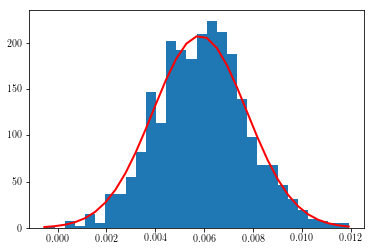

Beta GBD sampled copd, mean:  0.0056898796494705625
Beta GBD sampled copd, upper: 0.0043038969433682826
Beta GBD sampled copd, lower: 0.0070758623555728425


In [5]:
# sample 1000 estimates of beta from normal distributions using 95% uncertainties
# apply each result to the attributable fraction, AF = (1 \u2212 exp(-beta * delta(X)))
# use the resulting distribution of AF to determine mean AF, upper AF and lower AF (95% uncertainties)

# copd
mu, sigma = beta_copd_mean, beta_copd_sd # mean and standard deviation
s = np.random.normal(mu, sigma, 1000) # 1000 samples within the normal distribution
# verify the distribution
print abs(mu - np.mean(s)) < 0.01
print abs(sigma - np.std(s, ddof=1)) < 0.01
# Display the histogram of the samples, along with the probability density function:
count, bins, ignored = plt.hist(s, 30, normed=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=2, color='r')
plt.show()
beta_sampled_copd_mean, beta_sampled_copd_upper, beta_sampled_copd_lower = mean_confidence_interval(bins, confidence=0.95)
print 'Beta GBD sampled copd, mean:  ' + str(beta_sampled_copd_mean)
print 'Beta GBD sampled copd, upper: ' + str(beta_sampled_copd_upper)
print 'Beta GBD sampled copd, lower: ' + str(beta_sampled_copd_lower)

In [6]:
# create lookup table for attributable risk using the beta sampled with 1000 random samples: (1 \u2212 exp(-beta * delta(X)))
# for a given concentration of O3 between 0 and 200ppb
rr_copd_mean_lccmin  = np.empty([0])
rr_copd_lower_lccmin = np.empty([0])
rr_copd_upper_lccmin = np.empty([0])
rr_copd_mean_lccfifth  = np.empty([0])
rr_copd_lower_lccfifth = np.empty([0])
rr_copd_upper_lccfifth = np.empty([0])
for o3 in np.arange(0.0,200.0,0.1):
    if o3 < lccmin:
        rr_copd_mean_lccmin  = np.append(rr_copd_mean_lccmin, 1 - np.exp(-beta_sampled_copd_mean * (0)))
        rr_copd_lower_lccmin = np.append(rr_copd_lower_lccmin, 1 - np.exp(-beta_sampled_copd_lower * (0)))
        rr_copd_upper_lccmin = np.append(rr_copd_upper_lccmin, 1 - np.exp(-beta_sampled_copd_upper * (0)))
    if o3 >= lccmin:
        rr_copd_mean_lccmin  = np.append(rr_copd_mean_lccmin, 1 - np.exp(-beta_sampled_copd_mean * (o3 - lccmin)))
        rr_copd_lower_lccmin = np.append(rr_copd_lower_lccmin, 1 - np.exp(-beta_sampled_copd_lower * (o3 - lccmin)))
        rr_copd_upper_lccmin = np.append(rr_copd_upper_lccmin, 1 - np.exp(-beta_sampled_copd_upper * (o3 - lccmin)))
    if o3 < lccfifth:
        rr_copd_mean_lccfifth  = np.append(rr_copd_mean_lccfifth, 1 - np.exp(-beta_sampled_copd_mean * (0)))
        rr_copd_lower_lccfifth = np.append(rr_copd_lower_lccfifth, 1 - np.exp(-beta_sampled_copd_lower * (0)))
        rr_copd_upper_lccfifth = np.append(rr_copd_upper_lccfifth, 1 - np.exp(-beta_sampled_copd_upper * (0)))
    if o3 >= lccfifth:
        rr_copd_mean_lccfifth  = np.append(rr_copd_mean_lccfifth, 1 - np.exp(-beta_sampled_copd_mean * (o3 - lccfifth)))
        rr_copd_lower_lccfifth = np.append(rr_copd_lower_lccfifth, 1 - np.exp(-beta_sampled_copd_lower * (o3 - lccfifth)))
        rr_copd_upper_lccfifth = np.append(rr_copd_upper_lccfifth, 1 - np.exp(-beta_sampled_copd_upper * (o3 - lccfifth)))

In [7]:
o3_array = np.asarray(np.arange(0.0,200.0,0.1))
df_o3 = pd.DataFrame(o3_array)
df_o3['AF COPD mean with LCCmin'] = pd.Series(rr_copd_mean_lccmin)
df_o3['AF COPD lower with LCCmin'] = pd.Series(rr_copd_lower_lccmin)
df_o3['AF COPD upper with LCCmin'] = pd.Series(rr_copd_upper_lccmin)
df_o3['AF COPD mean with LCCfifth'] = pd.Series(rr_copd_mean_lccfifth)
df_o3['AF COPD lower with LCCfifth'] = pd.Series(rr_copd_lower_lccfifth)
df_o3['AF COPD upper with LCCfifth'] = pd.Series(rr_copd_upper_lccfifth)
df_o3.columns = ['O3 (ppb)', 'AF COPD mean with LCCmin', 'AF COPD upper with LCCmin', 'AF COPD lower with LCCmin', 'AF COPD mean with LCCfifth', 'AF COPD upper with LCCfifth', 'AF COPD lower with LCCfifth']
df_o3.tail()

,O3 (ppb),AF COPD mean with LCCmin,AF COPD upper with LCCmin,AF COPD lower with LCCmin,AF COPD mean with LCCfifth,AF COPD upper with LCCfifth,AF COPD lower with LCCfifth
1995,199.5,0.620748,0.700526,0.519719,0.606236,0.686208,0.505881
1996,199.6,0.620964,0.700738,0.519926,0.606459,0.686430,0.506093
1997,199.7,0.621180,0.700949,0.520132,0.606683,0.686652,0.506306
1998,199.8,0.621395,0.701161,0.520339,0.606907,0.686874,0.506518
1999,199.9,0.621611,0.701372,0.520545,0.607131,0.687095,0.506731


In [8]:
# save the lookup table for o3 attribule fraction from GBD2017
df_o3.to_csv('/nfs/a68/earlacoa/health/o3/o3_attributablefraction_gbd2017.csv')

### Turner et al., (2016)

In [57]:
# Malley (2016) uses the new ozone function to estimate updated long-term O3-attributable mortality
# From both COPD and respiratory
# GBD estimates COPD only
# They calculate the mortality for adults above 30 years using: Mort = basline_mort * (1 − exp(-beta * delta(X))) * pop

# Where delta(X) is the change in annual average daily maximum 8-h O3 concentration (ADM8h) for each grid
# consistent with the analysis from which the relative risk estimates were derived.
# For each day, 24 eight-hour rolling mean O3 concentrations were calculated as the average O3 concentration
# at the start hour and the following 7 h. The maximum of the 24 eight-hour O3 concentrations on each day were selected
# and averaged across the year to derive the ADM8h concentration in each grid.

# delta(X) is the model concentration relative to a low-concentration cutoffs (LCCs)
# below which we assume there is no effect of O3 exposure on mortality
# 2 LCCs to reflect uncertainty in the concentration response relationship
# LCC_min:   for minimum o3 exposure from ACS CPS-II population in Turner et al. (2016)
# LCC_fifth: for fifth percentile o3 exposure from ACS CPS-II population in Turner et al. (2016)
lccmin = 26.7
lccfifth = 31.1

# beta is from the hazard ratios (HR) from Turner et al., (2016)
# COPD: 1.14 (95% CI: 1.08, 1.21)
hr_copd_mean  = 1.14
hr_copd_sd    = (1.14 - 1.08) / 2
hr_copd_upper = 1.21
hr_copd_lower = 1.08
# Respiratory: 1.12 (95CI 1.08 1.16)
hr_resp_mean  = 1.12
hr_resp_sd    = (1.12 - 1.08) / 2
hr_resp_upper = 1.16
hr_resp_lower = 1.08
# HR = exp(beta * delta(Y))
# where delta(Y) is the increase per 10ppb, therefore:
# beta = ln(HR)/10
beta_copd_mean  = np.log(hr_copd_mean)/10
beta_copd_lower = np.log(hr_copd_lower)/10
beta_copd_upper = np.log(hr_copd_upper)/10
beta_copd_sd    = (beta_copd_mean - beta_copd_lower) / 2
beta_resp_mean  = np.log(hr_resp_mean)/10
beta_resp_lower = np.log(hr_resp_lower)/10
beta_resp_upper = np.log(hr_resp_upper)/10
beta_resp_sd    = (beta_resp_mean - beta_resp_lower) / 2

In [59]:
# function to determine mean and upper and lower confidence intervals at 95%
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * sp.stats.t._ppf((1+confidence)/2., n-1)
    return m, m-h, m+h

True
True


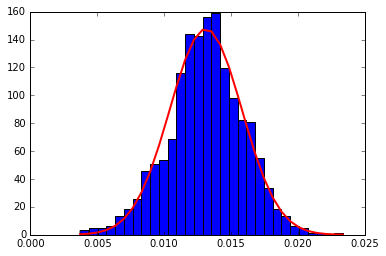

Beta sampled copd, mean:  0.0135243202739
Beta sampled copd, upper: 0.0113437841563
Beta sampled copd, lower: 0.0157048563915
True
True


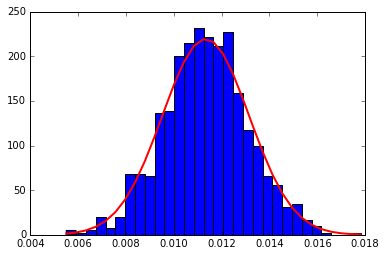

Beta sampled resp, mean:  0.0116585053774
Beta sampled resp, upper: 0.0102897908269
Beta sampled resp, lower: 0.013027219928


In [63]:
# sample 1000 estimates of beta from normal distributions using 95% uncertainties
# apply each result to the attributable fraction, AF = (1 − exp(-beta * delta(X)))
# use the resulting distribution of AF to determine mean AF, upper AF and lower AF (95% uncertainties)

# copd
mu, sigma = beta_copd_mean, beta_copd_sd # mean and standard deviation
s = np.random.normal(mu, sigma, 1000) # 1000 samples within the normal distribution
# verify the distribution
print abs(mu - np.mean(s)) < 0.01
print abs(sigma - np.std(s, ddof=1)) < 0.01
# Display the histogram of the samples, along with the probability density function:
count, bins, ignored = plt.hist(s, 30, normed=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=2, color='r')
plt.show()
beta_sampled_copd_mean, beta_sampled_copd_upper, beta_sampled_copd_lower = mean_confidence_interval(bins, confidence=0.95)
print 'Beta sampled copd, mean:  ' + str(beta_sampled_copd_mean)
print 'Beta sampled copd, upper: ' + str(beta_sampled_copd_upper)
print 'Beta sampled copd, lower: ' + str(beta_sampled_copd_lower)

# resp
mu, sigma = beta_resp_mean, beta_resp_sd # mean and standard deviation
s = np.random.normal(mu, sigma, 1000) # 1000 samples within the normal distribution
# verify the distribution
print abs(mu - np.mean(s)) < 0.01
print abs(sigma - np.std(s, ddof=1)) < 0.01
# Display the histogram of the samples, along with the probability density function:
count, bins, ignored = plt.hist(s, 30, normed=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=2, color='r')
plt.show()
beta_sampled_resp_mean, beta_sampled_resp_upper, beta_sampled_resp_lower = mean_confidence_interval(bins, confidence=0.95)
print 'Beta sampled resp, mean:  ' + str(beta_sampled_resp_mean)
print 'Beta sampled resp, upper: ' + str(beta_sampled_resp_upper)
print 'Beta sampled resp, lower: ' + str(beta_sampled_resp_lower)

In [64]:
# create lookup table for attributable risk using the beta sampled with 1000 random samples: (1 \u2212 exp(-beta * delta(X)))
# for a given concentration of O3 between 0 and 200ppb
rr_copd_mean_lccmin  = np.empty([0])
rr_copd_lower_lccmin = np.empty([0])
rr_copd_upper_lccmin = np.empty([0])
rr_resp_mean_lccmin  = np.empty([0])
rr_resp_lower_lccmin = np.empty([0])
rr_resp_upper_lccmin = np.empty([0])
rr_copd_mean_lccfifth  = np.empty([0])
rr_copd_lower_lccfifth = np.empty([0])
rr_copd_upper_lccfifth = np.empty([0])
rr_resp_mean_lccfifth  = np.empty([0])
rr_resp_lower_lccfifth = np.empty([0])
rr_resp_upper_lccfifth = np.empty([0])
for o3 in np.arange(0.0,200.0,0.1):
    if o3 < lccmin:
        rr_copd_mean_lccmin  = np.append(rr_copd_mean_lccmin, 1 - np.exp(-beta_sampled_copd_mean * (0)))
        rr_copd_lower_lccmin = np.append(rr_copd_lower_lccmin, 1 - np.exp(-beta_sampled_copd_lower * (0)))
        rr_copd_upper_lccmin = np.append(rr_copd_upper_lccmin, 1 - np.exp(-beta_sampled_copd_upper * (0)))
        rr_resp_mean_lccmin  = np.append(rr_resp_mean_lccmin, 1 - np.exp(-beta_sampled_resp_mean * (0)))
        rr_resp_lower_lccmin = np.append(rr_resp_lower_lccmin, 1 - np.exp(-beta_sampled_resp_lower * (0)))
        rr_resp_upper_lccmin = np.append(rr_resp_upper_lccmin, 1 - np.exp(-beta_sampled_resp_upper * (0)))
    if o3 >= lccmin:
        rr_copd_mean_lccmin  = np.append(rr_copd_mean_lccmin, 1 - np.exp(-beta_sampled_copd_mean * (o3 - lccmin)))
        rr_copd_lower_lccmin = np.append(rr_copd_lower_lccmin, 1 - np.exp(-beta_sampled_copd_lower * (o3 - lccmin)))
        rr_copd_upper_lccmin = np.append(rr_copd_upper_lccmin, 1 - np.exp(-beta_sampled_copd_upper * (o3 - lccmin)))
        rr_resp_mean_lccmin  = np.append(rr_resp_mean_lccmin, 1 - np.exp(-beta_sampled_resp_mean * (o3 - lccmin)))
        rr_resp_lower_lccmin = np.append(rr_resp_lower_lccmin, 1 - np.exp(-beta_sampled_resp_lower * (o3 - lccmin)))
        rr_resp_upper_lccmin = np.append(rr_resp_upper_lccmin, 1 - np.exp(-beta_sampled_resp_upper * (o3 - lccmin)))
    if o3 < lccfifth:
        rr_copd_mean_lccfifth  = np.append(rr_copd_mean_lccfifth, 1 - np.exp(-beta_sampled_copd_mean * (0)))
        rr_copd_lower_lccfifth = np.append(rr_copd_lower_lccfifth, 1 - np.exp(-beta_sampled_copd_lower * (0)))
        rr_copd_upper_lccfifth = np.append(rr_copd_upper_lccfifth, 1 - np.exp(-beta_sampled_copd_upper * (0)))
        rr_resp_mean_lccfifth  = np.append(rr_resp_mean_lccfifth, 1 - np.exp(-beta_sampled_resp_mean * (0)))
        rr_resp_lower_lccfifth = np.append(rr_resp_lower_lccfifth, 1 - np.exp(-beta_sampled_resp_lower * (0)))
        rr_resp_upper_lccfifth = np.append(rr_resp_upper_lccfifth, 1 - np.exp(-beta_sampled_resp_upper * (0)))
    if o3 >= lccfifth:
        rr_copd_mean_lccfifth  = np.append(rr_copd_mean_lccfifth, 1 - np.exp(-beta_sampled_copd_mean * (o3 - lccfifth)))
        rr_copd_lower_lccfifth = np.append(rr_copd_lower_lccfifth, 1 - np.exp(-beta_sampled_copd_lower * (o3 - lccfifth)))
        rr_copd_upper_lccfifth = np.append(rr_copd_upper_lccfifth, 1 - np.exp(-beta_sampled_copd_upper * (o3 - lccfifth)))
        rr_resp_mean_lccfifth  = np.append(rr_resp_mean_lccfifth, 1 - np.exp(-beta_sampled_resp_mean * (o3 - lccfifth)))
        rr_resp_lower_lccfifth = np.append(rr_resp_lower_lccfifth, 1 - np.exp(-beta_sampled_resp_lower * (o3 - lccfifth)))
        rr_resp_upper_lccfifth = np.append(rr_resp_upper_lccfifth, 1 - np.exp(-beta_sampled_resp_upper * (o3 - lccfifth)))


In [65]:
o3_array = np.asarray(np.arange(0.0,200.0,0.1))
df_o3_turner2016 = pd.DataFrame(o3_array)
df_o3_turner2016['AF COPD mean with LCCmin'] = pd.Series(rr_copd_mean_lccmin)
df_o3_turner2016['AF COPD lower with LCCmin'] = pd.Series(rr_copd_lower_lccmin)
df_o3_turner2016['AF COPD upper with LCCmin'] = pd.Series(rr_copd_upper_lccmin)
df_o3_turner2016['AF RESP mean with LCCmin'] = pd.Series(rr_resp_mean_lccmin)
df_o3_turner2016['AF RESP lower with LCCmin'] = pd.Series(rr_resp_lower_lccmin)
df_o3_turner2016['AF RESP upper with LCCmin'] = pd.Series(rr_resp_upper_lccmin)
df_o3_turner2016['AF COPD mean with LCCfifth'] = pd.Series(rr_copd_mean_lccfifth)
df_o3_turner2016['AF COPD lower with LCCfifth'] = pd.Series(rr_copd_lower_lccfifth)
df_o3_turner2016['AF COPD upper with LCCfifth'] = pd.Series(rr_copd_upper_lccfifth)
df_o3_turner2016['AF RESP mean with LCCfifth'] = pd.Series(rr_resp_mean_lccfifth)
df_o3_turner2016['AF RESP lower with LCCfifth'] = pd.Series(rr_resp_lower_lccfifth)
df_o3_turner2016['AF RESP upper with LCCfifth'] = pd.Series(rr_resp_upper_lccfifth)
df_o3_turner2016.columns = ['O3 (ppb)', 'AF COPD mean with LCCmin', 'AF COPD upper with LCCmin', 'AF COPD lower with LCCmin', 'AF COPD mean with LCCfifth', 'AF COPD upper with LCCfifth', 'AF COPD lower with LCCfifth', 'AF RESP mean with LCCmin', 'AF RESP upper with LCCmin', 'AF RESP lower with LCCmin', 'AF RESP mean with LCCfifth', 'AF RESP upper with LCCfifth', 'AF RESP lower with LCCfifth']
df_o3_turner2016.tail()

,O3 (ppb),AF COPD mean with LCCmin,AF COPD upper with LCCmin,AF COPD lower with LCCmin,AF COPD mean with LCCfifth,AF COPD upper with LCCfifth,AF COPD lower with LCCfifth,AF RESP mean with LCCmin,AF RESP upper with LCCmin,AF RESP lower with LCCmin,AF RESP mean with LCCfifth,AF RESP upper with LCCfifth,AF RESP lower with LCCfifth
1995,199.5,0.903383,0.933715,0.859171,0.866625,0.894717,0.831037,0.897459,0.928973,0.851963,0.859605,0.888506,0.823211
1996,199.6,0.903514,0.933820,0.859330,0.866780,0.894854,0.831211,0.897598,0.929085,0.852131,0.859768,0.888651,0.823393
1997,199.7,0.903644,0.933923,0.859490,0.866936,0.894991,0.831384,0.897736,0.929196,0.852299,0.859932,0.888796,0.823575
1998,199.8,0.903774,0.934027,0.859649,0.867091,0.895128,0.831558,0.897875,0.929307,0.852466,0.860095,0.888941,0.823756
1999,199.9,0.903904,0.934131,0.859808,0.867245,0.895264,0.831731,0.898013,0.929418,0.852633,0.860258,0.889085,0.823938


In [66]:
# save the lookup table for o3 attribule fraction from Turner et al., (2016)
df_o3_turner2016.to_csv('/nfs/a68/earlacoa/health/o3/o3_attributablefraction_turner2016.csv')

### GBD2016

In [67]:
# GBD2016 estimated long-term O3-attributable deaths associated with chronic obstructive pulmonary disease (COPD) only
# using 3-month running average of daily 1 hour maximum ozone values
# beta is from the hazard ratios (HR) from Jerret et al., (2009)
# COPD: [1.029 (95% CI 1.010, 1.048)] that was derived for total respiratory mortality
hr_gbd_copd_mean  = 1.029
hr_gbd_copd_sd    = (1.029 - 1.010) / 2
hr_gbd_copd_upper = 1.048
hr_gbd_copd_lower = 1.010
# HR = exp(beta * delta(Y))
# where delta(Y) is the increase per 10ppb, therefore:
# beta = ln(HR)/10
beta_gbd_copd_mean  = np.log(hr_gbd_copd_mean)/10
beta_gbd_copd_lower = np.log(hr_gbd_copd_lower)/10
beta_gbd_copd_upper = np.log(hr_gbd_copd_upper)/10
beta_gbd_copd_sd    = (beta_gbd_copd_mean - beta_gbd_copd_lower) / 2

# using larger LCC
lccmin_gbd = 33.3
lccfifth_gbd = 41.9

True
True


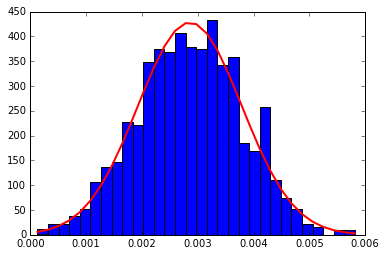

Beta GBD sampled copd, mean:  0.00297355215334
Beta GBD sampled copd, upper: 0.00234101777467
Beta GBD sampled copd, lower: 0.00360608653202


In [68]:
# sample 1000 estimates of beta from normal distributions using 95% uncertainties
# apply each result to the attributable fraction, AF = (1 \u2212 exp(-beta * delta(X)))
# use the resulting distribution of AF to determine mean AF, upper AF and lower AF (95% uncertainties)

# copd
mu, sigma = beta_gbd_copd_mean, beta_gbd_copd_sd # mean and standard deviation
s = np.random.normal(mu, sigma, 1000) # 1000 samples within the normal distribution
# verify the distribution
print abs(mu - np.mean(s)) < 0.01
print abs(sigma - np.std(s, ddof=1)) < 0.01
# Display the histogram of the samples, along with the probability density function:
count, bins, ignored = plt.hist(s, 30, normed=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=2, color='r')
plt.show()
beta_gbd_sampled_copd_mean, beta_gbd_sampled_copd_upper, beta_gbd_sampled_copd_lower = mean_confidence_interval(bins, confidence=0.95)
print 'Beta GBD sampled copd, mean:  ' + str(beta_gbd_sampled_copd_mean)
print 'Beta GBD sampled copd, upper: ' + str(beta_gbd_sampled_copd_upper)
print 'Beta GBD sampled copd, lower: ' + str(beta_gbd_sampled_copd_lower)

In [72]:
# create lookup table for attributable risk using the beta sampled with 1000 random samples: (1 \u2212 exp(-beta * delta(X)))
# for a given concentration of O3 between 0 and 200ppb
rr_gbd_copd_mean_lccmin  = np.empty([0])
rr_gbd_copd_lower_lccmin = np.empty([0])
rr_gbd_copd_upper_lccmin = np.empty([0])
rr_gbd_copd_mean_lccfifth  = np.empty([0])
rr_gbd_copd_lower_lccfifth = np.empty([0])
rr_gbd_copd_upper_lccfifth = np.empty([0])
for o3 in np.arange(0.0,200.0,0.1):
    if o3 < lccmin_gbd:
        rr_gbd_copd_mean_lccmin  = np.append(rr_gbd_copd_mean_lccmin, 1 - np.exp(-beta_gbd_sampled_copd_mean * (0)))
        rr_gbd_copd_lower_lccmin = np.append(rr_gbd_copd_lower_lccmin, 1 - np.exp(-beta_gbd_sampled_copd_lower * (0)))
        rr_gbd_copd_upper_lccmin = np.append(rr_gbd_copd_upper_lccmin, 1 - np.exp(-beta_gbd_sampled_copd_upper * (0)))
    if o3 >= lccmin_gbd:
        rr_gbd_copd_mean_lccmin  = np.append(rr_gbd_copd_mean_lccmin, 1 - np.exp(-beta_gbd_sampled_copd_mean * (o3 - lccmin_gbd)))
        rr_gbd_copd_lower_lccmin = np.append(rr_gbd_copd_lower_lccmin, 1 - np.exp(-beta_gbd_sampled_copd_lower * (o3 - lccmin_gbd)))
        rr_gbd_copd_upper_lccmin = np.append(rr_gbd_copd_upper_lccmin, 1 - np.exp(-beta_gbd_sampled_copd_upper * (o3 - lccmin_gbd)))
    if o3 < lccfifth_gbd:
        rr_gbd_copd_mean_lccfifth  = np.append(rr_gbd_copd_mean_lccfifth, 1 - np.exp(-beta_gbd_sampled_copd_mean * (0)))
        rr_gbd_copd_lower_lccfifth = np.append(rr_gbd_copd_lower_lccfifth, 1 - np.exp(-beta_gbd_sampled_copd_lower * (0)))
        rr_gbd_copd_upper_lccfifth = np.append(rr_gbd_copd_upper_lccfifth, 1 - np.exp(-beta_gbd_sampled_copd_upper * (0)))
    if o3 >= lccfifth_gbd:
        rr_gbd_copd_mean_lccfifth  = np.append(rr_gbd_copd_mean_lccfifth, 1 - np.exp(-beta_gbd_sampled_copd_mean * (o3 - lccfifth_gbd)))
        rr_gbd_copd_lower_lccfifth = np.append(rr_gbd_copd_lower_lccfifth, 1 - np.exp(-beta_gbd_sampled_copd_lower * (o3 - lccfifth_gbd)))
        rr_gbd_copd_upper_lccfifth = np.append(rr_gbd_copd_upper_lccfifth, 1 - np.exp(-beta_gbd_sampled_copd_upper * (o3 - lccfifth_gbd)))

In [73]:
o3_array = np.asarray(np.arange(0.0,200.0,0.1))
df_o3_gbd2016 = pd.DataFrame(o3_array)
df_o3_gbd2016['AF COPD mean with LCCmin'] = pd.Series(rr_gbd_copd_mean_lccmin)
df_o3_gbd2016['AF COPD lower with LCCmin'] = pd.Series(rr_gbd_copd_lower_lccmin)
df_o3_gbd2016['AF COPD upper with LCCmin'] = pd.Series(rr_gbd_copd_upper_lccmin)
df_o3_gbd2016['AF COPD mean with LCCfifth'] = pd.Series(rr_gbd_copd_mean_lccfifth)
df_o3_gbd2016['AF COPD lower with LCCfifth'] = pd.Series(rr_gbd_copd_lower_lccfifth)
df_o3_gbd2016['AF COPD upper with LCCfifth'] = pd.Series(rr_gbd_copd_upper_lccfifth)
df_o3_gbd2016.columns = ['O3 (ppb)', 'AF COPD mean with LCCmin', 'AF COPD upper with LCCmin', 'AF COPD lower with LCCmin', 'AF COPD mean with LCCfifth', 'AF COPD upper with LCCfifth', 'AF COPD lower with LCCfifth']
df_o3_gbd2016.tail()

,O3 (ppb),AF COPD mean with LCCmin,AF COPD upper with LCCmin,AF COPD lower with LCCmin,AF COPD mean with LCCfifth,AF COPD upper with LCCfifth,AF COPD lower with LCCfifth
1995,199.5,0.389944,0.450821,0.322318,0.374142,0.433523,0.308536
1996,199.6,0.390125,0.451019,0.322477,0.374328,0.433727,0.308698
1997,199.7,0.390307,0.451217,0.322635,0.374514,0.433932,0.308860
1998,199.8,0.390488,0.451415,0.322794,0.374700,0.434136,0.309022
1999,199.9,0.390669,0.451613,0.322952,0.374886,0.434340,0.309183


In [74]:
# save the lookup table for o3 attribule fraction from GBD2016
df_o3_gbd2016.to_csv('/nfs/a68/earlacoa/health/o3/o3_attributablefraction_gbd2016.csv')